In [2]:
from astropy.io import ascii 
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling import models, fitting
import os
import pickle
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
# #total catalog from COSMOS(2016)
# total = Table.read('./datas/cosmos2015_2.fits')

# #mass complete sample
# total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.516)]

In [4]:
#save index of overdense region
with open(f'./candidates/ras_final.txt', 'rb') as f:
    ras = pickle.load(f)

with open(f'./candidates/decs_final.txt', 'rb') as f:
    decs = pickle.load(f)

with open(f'./candidates/zs_final.txt', 'rb') as f:
    zs = pickle.load(f)
    
with open(f'./candidates/members_final.txt', 'rb') as f:
    members = pickle.load(f)


In [5]:
ras = np.array(ras)
decs = np.array(decs)
zs = np.array(zs)

# Draw Color-Magnitude Diagram

In [5]:
total = Table.read('./datas/cosmos2015_part')
total_z = total[(total['zphot'] > 0.65) & (total['zphot'] < 1.3) & (total['OType'] == 0) & (total['Mass'] > 9.516)]

In [6]:
x1 = np.linspace(0.7, 2, 100)
x2 = np.linspace(-1, 0.7, 100)
y1 = 3 * x1 + 1
y2 = [3.1] * len(x2)

In [7]:
age = cosmo.age(total_z['zphot']).to(u.yr).value
ssfr_mask  = 10**total_z['sSFR'] < 1 / 3 / age

quies =  total_z[ssfr_mask]
sf = total_z[~ssfr_mask]

(0.0, 8.2)

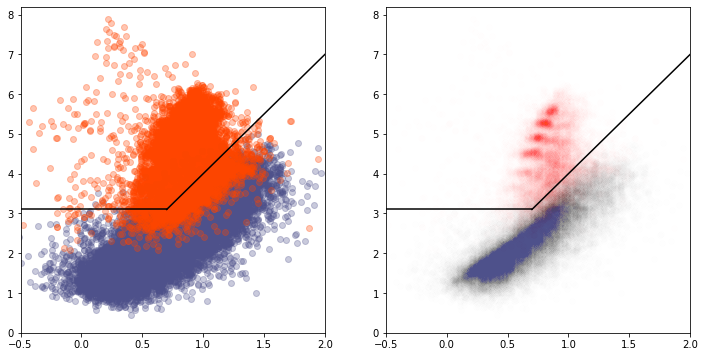

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].scatter(sf['RMag'] - sf['JMag'], sf['NUVMag'] - sf['RMag'], color = '#4e518b', alpha = .3, label = 'star-forming')
ax[0].scatter(quies['RMag'] - quies['JMag'], quies['NUVMag'] - quies['RMag'], color = '#FF4500', alpha = .3, label = 'quiescent')

ax[1].scatter(sf['RMag'] - sf['JMag'], sf['NUVMag'] - sf['RMag'], color = '#4e518b', alpha = .005, label = 'star-forming')
ax[1].scatter(quies['RMag'] - quies['JMag'], quies['NUVMag'] - quies['RMag'], color = '#FF4500', alpha = .005, label = 'quiescent')

ax[0].plot(x1, y1, color = 'black')
ax[0].plot(x2, y2, color = 'black')

ax[1].plot(x1, y1, color = 'black')
ax[1].plot(x2, y2, color = 'black')


ax[0].set_xlim(-0.5, 2.0)
ax[0].set_ylim(0, 8.2)
ax[1].set_xlim(-0.5, 2.0)
ax[1].set_ylim(0, 8.2)

# Bimodality of sSFR * 3H(z)

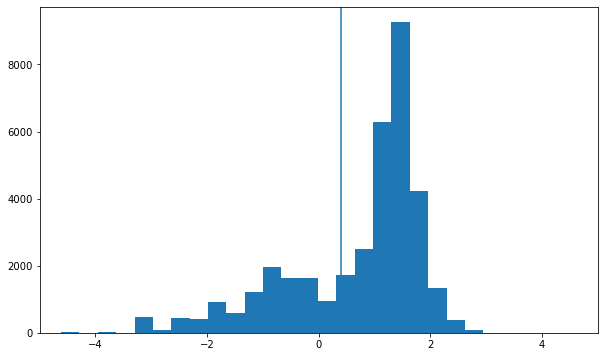

In [9]:
plt.figure(figsize = (10, 6))
plt.hist(np.log10(10**total_z['sSFR'] * 3 * cosmo.age(total_z['zphot']).to(u.yr).value), bins = 100)
plt.xlim(-5, 5)

plt.axvline(0.4)

In [10]:
flag = np.log10(10**total_z['sSFR'] * 3 * cosmo.age(total_z['zphot']).to(u.yr).value)
flag1 = flag[flag < 0.4]
flag2 = flag[flag > 0.0]

In [11]:
g_init = models.Gaussian1D()
fit_g = fitting.LevMarLSQFitter()

bins1 = np.arange(-5, 5, 0.4)
hist1, edges1 = np.histogram(flag1, bins = bins1)

g1 = fit_g(g_init, edges1[1:], hist1)

xs1 = np.linspace(edges1[1], edges1[-1], 100)
ys1 = g1(xs1)

###############################################
g_init = models.Gaussian1D()
fit_g = fitting.LevMarLSQFitter()

bins2 = np.arange(-5, 5, 0.4)
hist2, edges2 = np.histogram(flag2, bins = bins2)

g2 = fit_g(g_init, edges2[1:], hist2)

xs2 = np.linspace(edges2[1], edges2[-1], 100)
ys2 = g2(xs2)


mean1 = g1.mean.value
std1 = g1.stddev.value

mean2 = g2.mean.value
std2 = g2.stddev.value


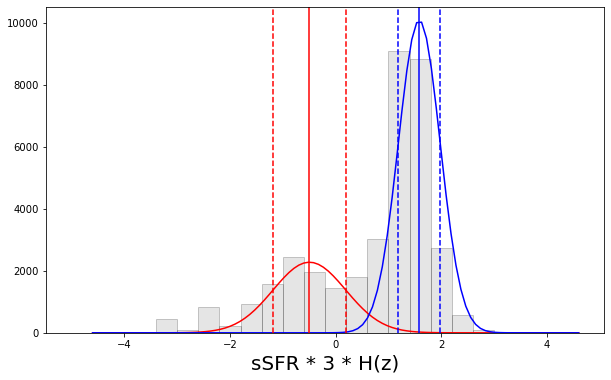

In [12]:
plt.figure(figsize = (10, 6))

plt.hist(flag, bins = bins1, color = 'grey', edgecolor = 'black', alpha = .2)
plt.plot(xs1, ys1, color = 'red') 
plt.plot(xs2, ys2, color = 'blue')
# plt.plot(xs1, ys1 + ys2)


plt.axvline(mean1, color = 'red')
plt.axvline(mean1 + 1 *std1, linestyle = '--', color = 'red')
plt.axvline(mean1 - 1 * std1, linestyle = '--', color = 'red')

plt.axvline(mean2, color = 'blue')
plt.axvline(mean2 + 1*std2, linestyle = '--', color = 'blue')
plt.axvline(mean2 - 1*std2, linestyle = '--', color = 'blue')

plt.xlabel('sSFR * 3 * H(z)', fontsize = 20)

plt.savefig('bimodality.png')

In [13]:
mean1 + 1*std1, mean2 - 1*std2

(0.19133148023451435, 1.185837332727821)

In [14]:
samp1 = total_z[flag < mean1 + 1*std1]
samp2 = total_z[(flag > mean1 + 1*std1) & (flag < mean2 - 1*std2)]
samp3 = total_z[flag > mean2 - 1*std2]

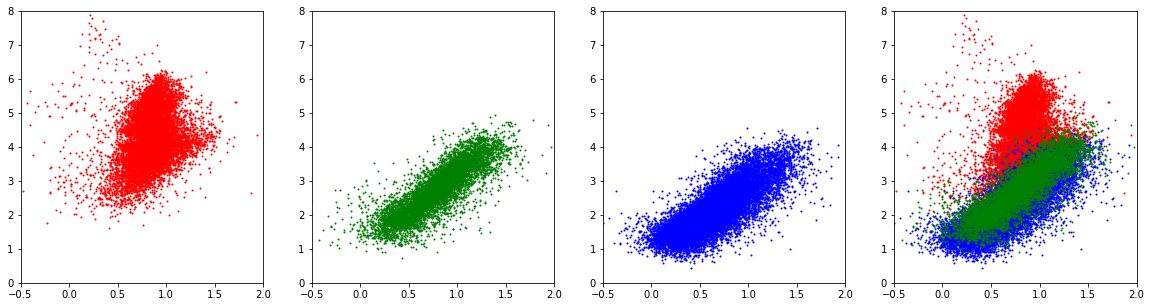

In [15]:
# sf['RMag'] - sf['JMag'], sf['NUVMag'] - sf['RMag']
fig, ax = plt.subplots(1, 4, figsize = (20, 5))


ax[0].scatter(samp1['RMag'] - samp1['JMag'], samp1['NUVMag'] - samp1['RMag'], s = 1, color = 'red')
ax[1].scatter(samp2['RMag'] - samp2['JMag'], samp2['NUVMag'] - samp2['RMag'], s = 1, color = 'green')
ax[2].scatter(samp3['RMag'] - samp3['JMag'], samp3['NUVMag'] - samp3['RMag'], s = 1, color = 'blue')

ax[3].scatter(samp1['RMag'] - samp1['JMag'], samp1['NUVMag'] - samp1['RMag'], s = 1, alpha = 1, color = 'red')
ax[3].scatter(samp3['RMag'] - samp3['JMag'], samp3['NUVMag'] - samp3['RMag'], s = 1, alpha = 1, color = 'blue')
ax[3].scatter(samp2['RMag'] - samp2['JMag'], samp2['NUVMag'] - samp2['RMag'], s = 1, alpha = 1, color = 'green')


ax[0].set_xlim(-0.5, 2)
ax[0].set_ylim(0, 8)
ax[1].set_xlim(-0.5, 2)
ax[1].set_ylim(0, 8)
ax[2].set_xlim(-0.5, 2)
ax[2].set_ylim(0, 8)
ax[3].set_xlim(-0.5, 2)
ax[3].set_ylim(0, 8)

plt.savefig('colormap.png')

## K-means cluster (unsupervised)

In [16]:
from sklearn.cluster import KMeans

In [17]:
km = KMeans(n_clusters = 2)

In [18]:
x = total_z['RMag'] - total_z['JMag']
y = total_z['NUVMag'] - total_z['RMag']

In [19]:
smask1 = (x > -0.5) & (x < 2.0)
smask2 = (y > 0) & (y < 8.2)

samp = total_z[smask1 & smask2]

In [20]:
xx = samp['RMag'] - samp['JMag']
yy = samp['NUVMag'] - samp['RMag']

In [21]:
xy = [[xx[i], yy[i]] for i in range(len(xx))]

In [25]:
y_predicted = km.fit_predict(xy)

In [26]:
mask0 = (y_predicted == 0)
mask1 = (y_predicted == 1)

(0.0, 8.2)

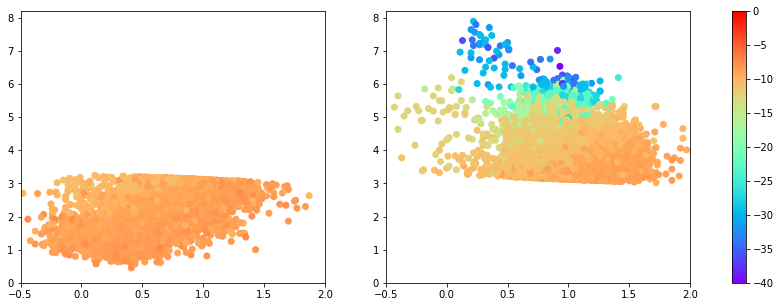

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].scatter(xx[mask0], yy[mask0], c = samp[mask0]['sSFR'], cmap = 'rainbow', vmin = -40, vmax = 0)
pix = ax[1].scatter(xx[mask1], yy[mask1], c = samp[mask1]['sSFR'], cmap = 'rainbow', vmin = -40, vmax = 0)

plt.colorbar(pix, ax = ax) 

ax[0].set_xlim(-0.5, 2.0)
ax[0].set_ylim(0, 8.2)
ax[1].set_xlim(-0.5, 2.0)
ax[1].set_ylim(0, 8.2)

## KNN classivier (supervised)

In [28]:
from sklearn.neighbors import KNeighborsClassifier


In [29]:
knn = KNeighborsClassifier(n_neighbors=5)

In [30]:
xtrain = sf['sSFR'].tolist() + quies['sSFR'].tolist()
ytrain = [0] * len(sf) + [1] * len(quies)

X = [[xtrain[i]] for i in range(len(xtrain))]

In [34]:
knn.fit(X, ytrain)

KNeighborsClassifier()

In [35]:
mem_ssfr = []
mem_r = []
mem_J = []
mem_NUV = []

for i in range(len(members[-1])):
    
    mask = total_z['Seq'] == members[-1][i]
    mem_ssfr.append(total_z[mask]['sSFR'][0])
    mem_r.append(total_z[mask]['RMag'][0])
    mem_J.append(total_z[mask]['JMag'][0])
    mem_NUV.append(total_z[mask]['NUVMag'][0])
    
    

In [36]:
mem_ssfr = [[x] for x in mem_ssfr]

In [37]:
y_score = knn.predict_proba(mem_ssfr)[:, 1]
y_score

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

# Evolutionary track

In [6]:
# load filter set
r = ascii.read('./filters/r_subaru.res')
J = ascii.read('./filters/J_uv.res')
NUV = ascii.read('./filters/galex2500.res')

In [7]:
fname = 'test.ised_ASCII' # 62 for solar metalliciity

In [8]:
with open(fname, 'r') as file:
    lines = file.readlines()

In [9]:
ages = lines[0] #256
ages = ages[15:-1]
ages = [x for x in ages.split(' ') if x is not ' ' and x is not '']
ages = [float(x) for x in ages]
ages = np.array(ages)

In [10]:
lambdas = lines[6][15:-1] #6900
lambdas = [x for x in lambdas.split(' ') if x is not ' ' and x is not '']
lambdas = [float(x) for x in lambdas]
lambdas = np.array(lambdas)

In [11]:
rmJ = []
NUVmr = []